# ISIC 2018 - Skin Cancer Project  - Task3: Disease Classification 

# 라이브러리 및 데이터 셋팅

In [ ]:
# # 캐글 설치
# !pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

100% 2.59G/2.59G [02:03<00:00, 19.4MB/s]
100% 2.59G/2.59G [02:03<00:00, 22.5MB/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


- 아무것도 안보고 나 혼자서 간단한 전처리부터 데이터셋 생성 및 베이스라인에 넣고 학습까지 해보기 

- 매번 캐글에서 다운받으려고 코인 넣어주기 귀찮아서 구글드라이브에서 gdown 하려는데 안되는 이슈 발생

  https://stackoverflow.com/questions/60739653/gdown-is-giving-permission-error-for-particular-file-although-it-is-opening-up-f

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown 1hBqTcWYEWdaydvRa7eSIOnEe-zu7RsZF

Downloading...
From: https://drive.google.com/uc?id=1hBqTcWYEWdaydvRa7eSIOnEe-zu7RsZF
To: /content/ham1000-segmentation-and-classification.zip
100% 2.78G/2.78G [00:43<00:00, 63.3MB/s]


In [ ]:
!unzip -q ham1000-segmentation-and-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 핸들링

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
import cv2
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score , recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dense 
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

## 데이터셋 검수

- 이미지 폴더안에 파일 개수 확인 - 10017개
- jpg형식의 이미지가 아닌 파일이 있는지 확인 - 텍스트파일 2개 존재
- 텍스트 파일 제거. 이미지는 총 10015장

In [ ]:
# images 폴더안에 10017개 파일 존재
len(os.listdir('/content/images'))

10017

In [ ]:
# 이미지 파일 확장자 확인
os.listdir('/content/images')[0][-3:]

'jpg'

In [ ]:
# jpg 이미지가 아닌 파일들 찾기 -> 텍스트파일 2개 발견 및 삭제
for i in os.listdir('/content/images'):
  if i[-3:] != 'jpg':
    print(i)

LICENSE.txt
ATTRIBUTION.txt


In [ ]:
!rm /content/images/ATTRIBUTION.txt
!rm /content/images/LICENSE.txt

In [ ]:
len(os.listdir('/content/images'))

10015

In [ ]:
# 이미지 경로 리스트 만들기

path = '/content/images/'
filenames = os.listdir(path)
image_path = []

for file in filenames:
  image_path.append(path + file)


In [ ]:
# # 이미지 중 무작위로 뽑아서 시각화
# random = np.random.randint(0,len(image_path))
# img = cv2.imread(image_path[random])
# plt.imshow(img)

In [ ]:
# # 이미지 사이즈 확인. (450, 600, 3) 이 아닌 다른 크기의 이미지가 있는지 검수.
# for path in image_path:
#   img = cv2.imread(path)
#   # print(img.shape)
#   if img.shape != (450, 600, 3):
#     print(path)

## 데이터프레임 수정 

In [ ]:
# 파일 이름과 라벨 값이 들어있는 csv파일
gt_df = pd.read_csv('/content/GroundTruth.csv')
gt_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


- 이미지 파일명과 라벨값이 들어있는 csv파일은 원-핫 인코딩처럼 7개의 라벨이 컬럼으로 있고 일치하는 라벨에는 1, 그외에는 0으로 표현되어있다
- 이대로 사용하기 불편하므로 파일명과 라벨 딕셔너리를 생성하고 데이터프레임의 image 컬럼을 for문 돌리면서 라벨 리스트를 생성, 데이터프레임에 label 컬럼으로 추가한다
- 컬럼에 image, label 두개만 남기면 파일명과 라벨 깔끔하게 나온다

In [ ]:
image_label = {}

for i in range(len(gt_df)):
  info_dict = dict(gt_df.iloc[i])
  for key, value in info_dict.items():
    if value == 1.0:
      image_label[info_dict['image']] = key


# image_label

In [ ]:
label_list = []

for img in gt_df['image']:
  label_list.append(image_label.get(img))

gt_df['label'] = label_list

In [ ]:
gt_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV


In [ ]:
gt_df = gt_df[['image', 'label']]
gt_df

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL
...,...,...
10010,ISIC_0034316,MEL
10011,ISIC_0034317,MEL
10012,ISIC_0034318,BKL
10013,ISIC_0034319,NV


- 문자 형태의 라벨들을 숫자로 변환하기 위해 사이킷런의 라벨 인코더 사용
- 사용법 : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
# labels = {'MEL':0, 
#           'NV': 1, 
#           'BCC':2, 
#           'AKIEC':3, 
#           'BKL':4, 
#           'DF':5, 
#           'VASC':6}

In [ ]:
le = LabelEncoder()
le.fit(labels)
gt_df.label = le.transform(gt_df.label)
gt_df

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,image,label
0,ISIC_0024306,5
1,ISIC_0024307,5
2,ISIC_0024308,5
3,ISIC_0024309,5
4,ISIC_0024310,4
...,...,...
10010,ISIC_0034316,4
10011,ISIC_0034317,4
10012,ISIC_0034318,2
10013,ISIC_0034319,5


In [ ]:
le.classes_

array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'], dtype='<U5')

## 테스트셋 생성

- 전체 이미지 10015장에서 라벨당 10%씩 분할해서 998장의 테스트셋 생성.
- 훈련셋은 9017장

In [ ]:
gt_df.groupby('label')['label'].value_counts()

label  label
0      0         327
1      1         514
2      2        1099
3      3         115
4      4        1113
5      5        6705
6      6         142
Name: label, dtype: int64

In [ ]:
gt_df.value_counts().groupby('label').sum()

label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
dtype: int64

In [ ]:
train_gt0 = gt_df[gt_df['label'] == 0].iloc[int(len(gt_df[gt_df['label'] == 0])*0.1):] # 295
train_gt1 = gt_df[gt_df['label'] == 1].iloc[int(len(gt_df[gt_df['label'] == 1])*0.1):] # 463
train_gt2 = gt_df[gt_df['label'] == 2].iloc[int(len(gt_df[gt_df['label'] == 2])*0.1):] # 990
train_gt3 = gt_df[gt_df['label'] == 3].iloc[int(len(gt_df[gt_df['label'] == 3])*0.1):] # 104
train_gt4 = gt_df[gt_df['label'] == 4].iloc[int(len(gt_df[gt_df['label'] == 4])*0.1):] # 1002
train_gt5 = gt_df[gt_df['label'] == 5].iloc[int(len(gt_df[gt_df['label'] == 5])*0.1):] # 6035
train_gt6 = gt_df[gt_df['label'] == 6].iloc[int(len(gt_df[gt_df['label'] == 6])*0.1):] # 128   = 9017

In [ ]:
test_gt0 = gt_df[gt_df['label'] == 0].iloc[:int(len(gt_df[gt_df['label'] == 0])*0.1)] # 32
test_gt1 = gt_df[gt_df['label'] == 1].iloc[:int(len(gt_df[gt_df['label'] == 1])*0.1)] # 51
test_gt2 = gt_df[gt_df['label'] == 2].iloc[:int(len(gt_df[gt_df['label'] == 2])*0.1)] # 109
test_gt3 = gt_df[gt_df['label'] == 3].iloc[:int(len(gt_df[gt_df['label'] == 3])*0.1)] # 11
test_gt4 = gt_df[gt_df['label'] == 4].iloc[:int(len(gt_df[gt_df['label'] == 4])*0.1)] # 111
test_gt5 = gt_df[gt_df['label'] == 5].iloc[:int(len(gt_df[gt_df['label'] == 5])*0.1)] # 670
test_gt6 = gt_df[gt_df['label'] == 6].iloc[:int(len(gt_df[gt_df['label'] == 6])*0.1)] # 14

In [ ]:
print(len(train_gt0), len(train_gt1), len(train_gt2), len(train_gt3), len(train_gt4), len(train_gt5), len(train_gt6))
print(len(test_gt0), len(test_gt1), len(test_gt2), len(test_gt3), len(test_gt4), len(test_gt5), len(test_gt6))

295 463 990 104 1002 6035 128
32 51 109 11 111 670 14


In [ ]:
print(np.sum([295, 463, 990, 104, 1002, 6035, 128]) , np.sum([32, 51, 109, 11, 111, 670, 14]))
print(np.sum([295, 463, 990, 104, 1002, 6035, 128]) + np.sum([32, 51, 109, 11, 111, 670, 14]))

9017 998
10015


- 32+51+109+11+111+670+14 = 998
- 각 라벨당 10%씩 가져온 테스트셋은 총 998장
- 훈련셋은 총 9017장
- 다 합치면 10015장. 누락없이 ok.
- train_df, test_df로 concat

In [ ]:
train_df = pd.concat([train_gt0, train_gt1, train_gt2, train_gt3, train_gt4, train_gt5, train_gt6])
train_df

,image,label
876,ISIC_0025182,0
890,ISIC_0025196,0
941,ISIC_0025247,0
958,ISIC_0025264,0
1013,ISIC_0025319,0
...,...,...
9538,ISIC_0033844,6
9663,ISIC_0033969,6
9685,ISIC_0033991,6
9890,ISIC_0034196,6


In [ ]:
test_df = pd.concat([test_gt0, test_gt1, test_gt2, test_gt3, test_gt4, test_gt5, test_gt6])
test_df

,image,label
23,ISIC_0024329,0
66,ISIC_0024372,0
112,ISIC_0024418,0
144,ISIC_0024450,0
157,ISIC_0024463,0
...,...,...
598,ISIC_0024904,6
891,ISIC_0025197,6
938,ISIC_0025244,6
943,ISIC_0025249,6


## 간단한 전처리 및 데이터셋 생성

In [ ]:
main_path = '/content/images/'

train_paths, test_paths = [], []

for filename in train_df.image:
  train_paths.append(main_path + filename + '.jpg')

for filename in test_df.image:
  test_paths.append(main_path + filename + '.jpg')

train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

train_labels = train_df.label.values
test_labels = test_df.label.values

len(train_paths), len(train_labels), len(test_paths), len(test_labels)
######################################################################################################################################
s = np.arange(len(train_paths))
np.random.shuffle(s)

train_paths = train_paths[s]
train_labels = train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#######################################################################################################################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (256,256))
  img = img/255
  return img, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

In [ ]:
# for i,j in tqdm(train_dataset):
#   # print(i.shape)
#   if i.shape != (16, 224, 224, 3):
#     print(i)

## 간단한 CNN으로 베이스라인 생성

In [ ]:
model = Sequential()
model.add(layers.Conv2D(128,3,padding='same', input_shape=[256,256,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(128,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(256,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(512,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(7, activation='softmax'))

opt = keras.optimizers.SGD()
# opt = keras.optimizers.SGD()
loss = keras.losses.SparseCategoricalCrossentropy()


es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=40, verbose=1, callbacks=[es])

- 계속 같은 accuracy가 나오는 이슈 발생

```
Epoch 1/40
564/564 [==============================] - 273s 482ms/step - loss: 1.1933 - accuracy: 0.6632
Epoch 2/40
564/564 [==============================] - 275s 488ms/step - loss: 1.1568 - accuracy: 0.6691
Epoch 3/40
564/564 [==============================] - 339s 602ms/step - loss: 1.1463 - accuracy: 0.6693
Epoch 4/40
564/564 [==============================] - 378s 670ms/step - loss: 1.1462 - accuracy: 0.6693
Epoch 5/40
564/564 [==============================] - 330s 584ms/step - loss: 1.1433 - accuracy: 0.6693
Epoch 6/40
564/564 [==============================] - 315s 558ms/step - loss: 1.1397 - accuracy: 0.6693
Epoch 7/40
564/564 [==============================] - 316s 560ms/step - loss: 1.1374 - accuracy: 0.6693
Epoch 8/40
564/564 [==============================] - 295s 524ms/step - loss: 1.1390 - accuracy: 0.6693
Epoch 9/40
564/564 [==============================] - 281s 499ms/step - loss: 1.1369 - accuracy: 0.6693
Epoch 10/40
564/564 [==============================] - 282s 500ms/step - loss: 1.1359 - accuracy: 0.6693
```

SGD, Adam 둘다 같은 현상이 발생

검증셋을 만들고 224x224에서 256x256으로 변경하여 학습진행 => 정상적으로 잘 돌아감. 사이즈가 문제였나???

In [ ]:
model.evaluate(test_dataset)

- 0.71. 높게 나온다고 해서 이 값이 신뢰도가 있는것은 아니다
- 클래스 불균형 때문.

## 모델 검증

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (256,256))
  img = img/255
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

In [ ]:
y_pred = model.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')

- 정확도는 나쁘지 않게 나오지만 역시 클래스 불균형으로 정밀도와 재현율은 개판이다

# Class Imbalance 문제

In [ ]:
train_df

,image,label
876,ISIC_0025182,0
890,ISIC_0025196,0
941,ISIC_0025247,0
958,ISIC_0025264,0
1013,ISIC_0025319,0
...,...,...
9538,ISIC_0033844,6
9663,ISIC_0033969,6
9685,ISIC_0033991,6
9890,ISIC_0034196,6


In [ ]:
label_count = train_df.value_counts().groupby('label').sum()
label_count

label
0     295
1     463
2     990
3     104
4    1002
5    6035
6     128
dtype: int64

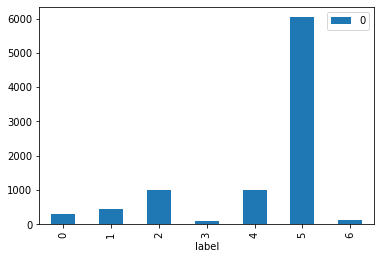

In [ ]:
pd.DataFrame(label_count).plot(kind='bar')

- 보다시피 5번이 6000장으로 극단적으로 많고 2,4번은 900~1000장 정도, 나머지는 100, 300, 400장으로 극단적으로 적다
- 이렇게 클래스간 불균형이 심하면 학습에 악영향을 미친다. 
- 5번만 찍어도 정확도가 0.5이상 나오니 신뢰도가 있다고 할 수 없다.


--- 
- 클래스 불균형 해결 방법 참고 
  - https://techblog-history-younghunjo1.tistory.com/74
  - https://3months.tistory.com/414

  => 부족한 라벨은 증강을, 과한 라벨은 감소를. 하지만 데이터는 무작정 줄이기엔 아까우니 먼저 증강을 해보고 클래스간 웨이트 밸런싱도 해본다음에 다운샘플링 해보자


## 0,3,6 라벨 Augmentation

- 이미지가 많이 부족한 0, 3, 6번 라벨 2배로 증강해서 train_df에 추가하고 한번에 경로따면 될듯??

  => 0,3,6 라벨 증강시켜봤고 이제 5번 NV 제외하고 나머지 라벨들 이미지 개수 맞춰서 증강

In [ ]:
train_gt0 = gt_df[gt_df['label'] == 0].iloc[int(len(gt_df[gt_df['label'] == 0])*0.1):] # 295
train_gt1 = gt_df[gt_df['label'] == 1].iloc[int(len(gt_df[gt_df['label'] == 1])*0.1):] # 463
train_gt2 = gt_df[gt_df['label'] == 2].iloc[int(len(gt_df[gt_df['label'] == 2])*0.1):] # 990
train_gt3 = gt_df[gt_df['label'] == 3].iloc[int(len(gt_df[gt_df['label'] == 3])*0.1):] # 104
train_gt4 = gt_df[gt_df['label'] == 4].iloc[int(len(gt_df[gt_df['label'] == 4])*0.1):] # 1002
# train_gt5 = gt_df[gt_df['label'] == 5].iloc[int(len(gt_df[gt_df['label'] == 5])*0.1):] # 6035
train_gt6 = gt_df[gt_df['label'] == 6].iloc[int(len(gt_df[gt_df['label'] == 6])*0.1):] # 128   = 9017

In [ ]:
# # 증강할 라벨들의 이미지 경로와 라벨 리스트 생성
# main_path = '/content/images/'

# train_path0, train_path1, train_path2, train_path3, train_path4, train_path6 = [], [], [], [], [], []

# for file in train_gt0.image:
#   train_path0.append(main_path + file + '.jpg')

# for file in train_gt1.image:
#   train_path1.append(main_path + file + '.jpg')

# for file in train_gt2.image:
#   train_path2.append(main_path + file + '.jpg')

# for file in train_gt3.image:
#   train_path3.append(main_path + file + '.jpg')

# for file in train_gt4.image:
#   train_path4.append(main_path + file + '.jpg')

# for file in train_gt6.image:
#   train_path6.append(main_path + file + '.jpg')

# train_label0, train_label1, train_label2, train_label3, train_label4, train_label6 = train_gt0.label.values, train_gt1.label.values, train_gt2.label.values, train_gt3.label.values, train_gt4.label.values, train_gt6.label.values

In [ ]:
main_path = '/content/images/'

train_path0, train_path1, train_path2, train_path3, train_path4, train_path6 = [], [], [], [], [], []

gt_list = [train_gt0.image, train_gt1.image, train_gt2.image, train_gt3.image, train_gt4.image, train_gt6.image]
path_list = [train_path0, train_path1, train_path2, train_path3, train_path4, train_path6]


for filename, path in zip(gt_list, path_list):
    for file in filename:
            path.append(main_path + file + '.jpg')
        
train_label0, train_label1, train_label2, train_label3, train_label4, train_label6 = train_gt0.label.values, train_gt1.label.values, train_gt2.label.values, train_gt3.label.values, train_gt4.label.values, train_gt6.label.values


In [ ]:
path_list = [train_path0, train_path1, train_path2, train_path3, train_path4, train_path6]
for i in path_list:
    print(len(i))

295
463
990
104
1002
128


In [ ]:
# train_label0, train_label3, train_label6

In [ ]:
!mkdir /content/aug_image/

- Augmentation용 간단한 이미지 전처리 함수

In [ ]:

def random_image(img): # 좌우, 위아래 반전 / 반시계 90도 회전 3가지
  random = np.random.randint(0,2)
  if random == 0:
    image = cv2.flip(img,1) # 1은 좌우반전
  elif random == 1:
    image = cv2.flip(img,0) # 0은 위아래 반전
  elif random == 2:
    mat = cv2.getRotationMatrix2D(tuple(np.array(img.shape[:2]) /2), 90, 1.0) # 반시계방향으로 90도 회전
    image = cv2.warpAffine(img, mat, img.shape[:2])
  # elif random == 3:

  return image

## 이미지 전처리 

In [ ]:
def rotation(img, angle=90):
    angle = int(np.random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def brightness(img, low, high):
    value = np.random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def contrast(gray, min_val, max_val):
    #gray = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    alpha = int(np.random.uniform(min_val, max_val)) # Contrast control
    adjusted = cv2.convertScaleAbs(gray, alpha=alpha)
    return adjusted

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[400,400, 3])

  return cropped_image


def random_image(img): # 좌우, 위아래 반전 / 반시계 90도 회전 3가지
  random = np.random.randint(0,5)
  if random == 0:
    image = cv2.flip(img,1) # 1은 좌우반전, horizontal_flip

  elif random == 1:
    image = cv2.flip(img,0) # 0은 위아래 반전, vertical_flip
    
  elif random == 2:
    image = rotation(img) # -90도에서 90도 범위 내 랜덤으로 rotation.

  elif random == 3:
    image = brightness(img, 0.5, 1.5)

  elif random == 4:
    #   image = contrast(img, 0.8, 1.5)
    image = np.array(random_crop(img))

  return image

In [ ]:
# import cv2
# import numpy as np
# import argparse
# import os
# import matplotlib.pyplot as plt

# # ap = argparse.ArgumentParser()
# # ap.add_argument("-i", "--image", required=True, help="Image path to the directory")
# # args = vars(ap.parse_args())
# # path = args['image']

# path = train_path0[81]

# # 입력 받은 이미지를 불러옵니다.
# src = cv2.imread(path)

# # hsv 컬러 형태로 변형합니다.
# hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
# # h, s, v로 컬러 영상을 분리 합니다. 
# h, s, v = cv2.split(hsv)
# # v값을 히스토그램 평활화를 합니다.
# equalizedV = cv2.equalizeHist(v)
# # h,s,equalizedV를 합쳐서 새로운 hsv 이미지를 만듭니다.
# hsv2 = cv2.merge([h,s,equalizedV])
# # 마지막으로 hsv2를 다시 BGR 형태로 변경합니다.
# hsvDst = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)

# # YCrCb 컬러 형태로 변환합니다.
# yCrCb = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)
# # y, Cr, Cb로 컬러 영상을 분리 합니다.
# y, Cr, Cb = cv2.split(yCrCb)
# # y값을 히스토그램 평활화를 합니다.
# equalizedY = cv2.equalizeHist(y)
# # equalizedY, Cr, Cb를 합쳐서 새로운 yCrCb 이미지를 만듭니다.
# yCrCb2 = cv2.merge([equalizedY, Cr, Cb])
# # 마지막으로 yCrCb2를 다시 BGR 형태로 변경합니다.
# yCrCbDst = cv2.cvtColor(yCrCb2, cv2.COLOR_YCrCb2BGR)

# # src, hsv, YCrCb 각각을 출력합니다.
# cv2_imshow(src)
# cv2_imshow(hsvDst)
# cv2_imshow(yCrCbDst)


In [ ]:
from google.colab.patches import cv2_imshow

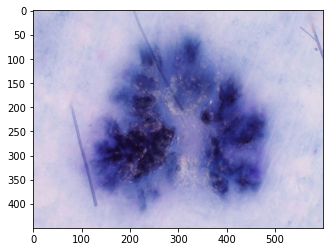

In [ ]:
img = cv2.imread(train_path0[81])
ran_img = random_image(img)
plt.imshow(ran_img)

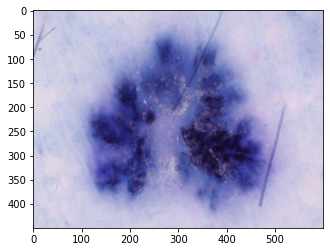

In [ ]:
img = cv2.imread(train_path0[81])
plt.imshow(img)

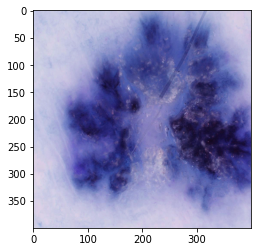

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[400,400, 3])

  return cropped_image

img = cv2.imread(train_path0[81])
co_img = random_crop(img)
plt.imshow(co_img)

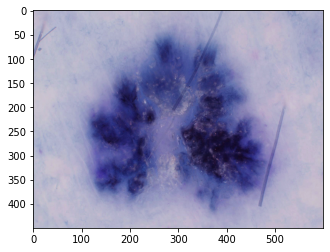

In [ ]:
img = cv2.imread(train_path0[81])
co_img = contrast(img, 0.9)
plt.imshow(co_img)
# plt.imshow(img)
# zo_img = zoom(img, 0.2)
# plt.imshow(zo_img)

## 일부 라벨들 2배 이상 증강

In [ ]:
aug_label0 = pd.DataFrame()

for idx,i in enumerate(np.random.randint(0,len(train_path0), 1000)):  
    series = train_gt0.iloc[i]
    filename = series['image'] + '_' + str(idx)
    label = series['label']
    new_series = pd.Series(data=[filename, label], index=['image', 'label'])

    dd = pd.DataFrame(new_series).T
    aug_label0 = pd.concat([aug_label0, dd])



### 0,3,6 라벨 2배로 증강

In [ ]:
# 이건 전체 이미지를 다 만들때 사용.

# aug_train_path0, aug_train_path3, aug_train_path6 = [], [], []
aug_train_filename0, aug_train_filename3, aug_train_filename6 = [], [], []


for idx,path in enumerate(train_path0):
  filename = path.split('/')[-1][:-4]  # ISIC_0025182
  image = cv2.imread(path)
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename0.append(f'aug_{filename}') # 리스트에 이미지 파일명 저장
  # aug_train_path0.append(p) # 리스트에 이미지 경로저장


for idx,path in enumerate(train_path3):
  filename = path.split('/')[-1][:-4]
  image = cv2.imread(path)
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename3.append(f'aug_{filename}')
  # aug_train_path3.append(p)


for idx,path in enumerate(train_path6):
  filename = path.split('/')[-1][:-4]
  image = cv2.imread(path)
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename6.append(f'aug_{filename}')
  # aug_train_path6.append(p)

### 원하는 만큼 랜덤으로 뽑아서 증강

label

0    : 295

1    : 463

2     : 990

3    : 104

4   : 1002

5  :  6035

6 :    128

---
0,3,6라벨 1500장, 3000장 증강 -> 5번 제외 3000장 증강 

-> 5번 라벨 이미지 개수에 맞춰서 5번제외 다른 라벨들 5000장 정도로 맞추기

(0-5000, 1-5000, 2-4000, 3-5000, 4-4000, 6-5000)

In [ ]:
# aug_train_path0, aug_train_path3, aug_train_path6 = [], [], []
aug_train_filename0,aug_train_filename1,aug_train_filename2, aug_train_filename3, aug_train_filename4, aug_train_filename6 = [], [], [], [], [], []


for idx,i in enumerate(np.random.randint(0,len(train_path0), 5000)):
  filename = train_path0[i].split('/')[-1][:-4]  # ISIC_0025182
  image = cv2.imread(train_path0[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename0.append(f'aug_{filename}_{idx}') # 리스트에 이미지 파일명 저장
  # aug_train_path0.append(p) # 리스트에 이미지 경로저장

for idx,i in enumerate(np.random.randint(0,len(train_path1), 5000)):
  filename = train_path1[i].split('/')[-1][:-4]  # ISIC_0025182
  image = cv2.imread(train_path1[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename1.append(f'aug_{filename}_{idx}') # 리스트에 이미지 파일명 저장
  # aug_train_path0.append(p) # 리스트에 이미지 경로저장

for idx,i in enumerate(np.random.randint(0,len(train_path2), 4000)):
  filename = train_path2[i].split('/')[-1][:-4]  # ISIC_0025182
  image = cv2.imread(train_path2[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename2.append(f'aug_{filename}_{idx}') # 리스트에 이미지 파일명 저장
  # aug_train_path0.append(p) # 리스트에 이미지 경로저장


for idx,i in enumerate(np.random.randint(0,len(train_path3), 5000)):
  filename = train_path3[i].split('/')[-1][:-4]
  image = cv2.imread(train_path3[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename3.append(f'aug_{filename}_{idx}')
  # aug_train_path3.append(p)

for idx,i in enumerate(np.random.randint(0,len(train_path4), 4000)):
  filename = train_path4[i].split('/')[-1][:-4]
  image = cv2.imread(train_path4[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename4.append(f'aug_{filename}_{idx}')
  # aug_train_path3.append(p)


for idx,i in enumerate(np.random.randint(0,len(train_path6), 5000)):
  filename = train_path6[i].split('/')[-1][:-4]
  image = cv2.imread(train_path6[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename6.append(f'aug_{filename}_{idx}')
  # aug_train_path6.append(p)

- 0,3,6 라벨 3000장씩 증강

In [ ]:
# aug_train_path0, aug_train_path3, aug_train_path6 = [], [], []
aug_train_filename0, aug_train_filename3, aug_train_filename6 = [], [], []


for idx,i in enumerate(np.random.randint(0,len(train_path0), 3000)):
  filename = train_path0[i].split('/')[-1][:-4]  # ISIC_0025182
  image = cv2.imread(train_path0[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename0.append(f'aug_{filename}_{idx}') # 리스트에 이미지 파일명 저장
  # aug_train_path0.append(p) # 리스트에 이미지 경로저장



for idx,i in enumerate(np.random.randint(0,len(train_path3), 3000)):
  filename = train_path3[i].split('/')[-1][:-4]
  image = cv2.imread(train_path3[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename3.append(f'aug_{filename}_{idx}')
  # aug_train_path3.append(p)



for idx,i in enumerate(np.random.randint(0,len(train_path6), 3000)):
  filename = train_path6[i].split('/')[-1][:-4]
  image = cv2.imread(train_path6[i])
  img = random_image(image)
  p = f'/content/aug_image/aug_{filename}_{idx}.jpg'
  cv2.imwrite(p, img)
  aug_train_filename6.append(f'aug_{filename}_{idx}')
  # aug_train_path6.append(p)

In [ ]:
len(os.listdir('/content/aug_image/'))

9000

In [ ]:
# !rm /content/aug_image/*

In [ ]:
aug_train_df = train_df.copy()
aug_train_df

,image,label
876,ISIC_0025182,0
890,ISIC_0025196,0
941,ISIC_0025247,0
958,ISIC_0025264,0
1013,ISIC_0025319,0
...,...,...
9538,ISIC_0033844,6
9663,ISIC_0033969,6
9685,ISIC_0033991,6
9890,ISIC_0034196,6


In [ ]:
# (0-5000, 1-5000, 2-4000, 3-5000, 4-4000, 6-5000)
label0 = np.zeros(3000)
label3 = np.zeros(3000) + 3
label6 = np.zeros(3000) + 6
# label0 = np.zeros(5000)
# label1 = np.zeros(5000) + 1
# label2 = np.zeros(4000) + 2
# label3 = np.zeros(5000) + 3
# label4 = np.zeros(4000) + 4
# label6 = np.zeros(5000) + 6

In [ ]:
# aug_df0 = pd.DataFrame({'image': aug_train_filename0, 'label': label0})
# aug_df1 = pd.DataFrame({'image': aug_train_filename1, 'label': label1})
# aug_df2 = pd.DataFrame({'image': aug_train_filename2, 'label': label2})
# aug_df3 = pd.DataFrame({'image': aug_train_filename3, 'label': label3})
# aug_df4 = pd.DataFrame({'image': aug_train_filename4, 'label': label4})
# aug_df6 = pd.DataFrame({'image': aug_train_filename6, 'label': label6})
# aug_train_df = pd.concat([aug_train_df, aug_df0, aug_df1, aug_df2, aug_df3, aug_df4, aug_df6])
aug_df0 = pd.DataFrame({'image': aug_train_filename0, 'label': label0})
aug_df3 = pd.DataFrame({'image': aug_train_filename3, 'label': label3})
aug_df6 = pd.DataFrame({'image': aug_train_filename6, 'label': label6})
aug_train_df = pd.concat([aug_train_df, aug_df0, aug_df3, aug_df6])
aug_train_df

,image,label
876,ISIC_0025182,0.0
890,ISIC_0025196,0.0
941,ISIC_0025247,0.0
958,ISIC_0025264,0.0
1013,ISIC_0025319,0.0
...,...,...
2995,aug_ISIC_0026456_2995,6.0
2996,aug_ISIC_0033749_2996,6.0
2997,aug_ISIC_0031706_2997,6.0
2998,aug_ISIC_0030104_2998,6.0


In [ ]:
aug_train_df.label = aug_train_df.label.astype(int)
aug_train_df

,image,label
876,ISIC_0025182,0
890,ISIC_0025196,0
941,ISIC_0025247,0
958,ISIC_0025264,0
1013,ISIC_0025319,0
...,...,...
2995,aug_ISIC_0026456_2995,6
2996,aug_ISIC_0033749_2996,6
2997,aug_ISIC_0031706_2997,6
2998,aug_ISIC_0030104_2998,6


In [ ]:
aug_train_df.value_counts().groupby('label').sum()

label
0    3295
1     463
2     990
3    3104
4    1002
5    6035
6    3128
dtype: int64

- 늘어난 이미지는 527장... 너무 적은디..
- 어떻게 해야 한 장의 이미지를 여러개 저장할때 이름을 안겹치게 할수 있을까???
- 아니면 전부 넘파이배열로 넣어버리고 ImageDataGenrator쓸까??

---

=> 인덱스 범위 설정해서 랜덤으로 1000개 뽑기. 0,3,6번 라벨 각각 1000장씩 총 3000장 증강함 => 3000장씩 증강

---

=> 5번 NV 제외한 나머지 라벨 3000장씩 증강

## 증강한 이미지 이동 및 데이터셋 생성

In [ ]:
len(os.listdir('/content/images')), len(os.listdir('/content/aug_image'))

(10015, 9000)

In [ ]:
!mv /content/aug_image/* /content/images

In [ ]:
len(os.listdir('/content/images'))

19015

In [ ]:
main_path = '/content/images/'
# aug_path - '/content/aug_image/'

aug_train_paths, test_paths = [], []

for filename in aug_train_df.image:
  aug_train_paths.append(main_path + filename + '.jpg')

for filename in test_df.image:
  test_paths.append(main_path + filename + '.jpg')

aug_train_paths = np.array(aug_train_paths)
test_paths = np.array(test_paths)

aug_train_labels = aug_train_df.label.values
test_labels = test_df.label.values

len(aug_train_paths), len(aug_train_labels), len(test_paths), len(test_labels)

(18017, 18017, 998, 998)

In [ ]:
main_path = '/content/images/'
test_paths = []

for filename in test_df.image:
  test_paths.append(main_path + filename + '.jpg')

test_paths = np.array(test_paths)

test_labels = test_df.label.values

len(test_paths), len(test_labels)


(998, 998)

## 데이터셋 생성 및 베이스라인 모델 학습+검증

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (256,256))
  img = img/255
  return img, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(128,3,padding='same', input_shape=[256,256,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(128,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(256,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(512,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(7, activation='softmax'))

opt = keras.optimizers.SGD()
# opt = keras.optimizers.SGD()
loss = keras.losses.SparseCategoricalCrossentropy()


es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=40, verbose=1, callbacks=[es])

Epoch 1/40
478/478 [==============================] - 81s 169ms/step - loss: 1.0066 - accuracy: 0.6453 - val_loss: 1.1426 - val_accuracy: 0.6317
Epoch 2/40
478/478 [==============================] - 78s 164ms/step - loss: 0.9138 - accuracy: 0.6694 - val_loss: 1.0954 - val_accuracy: 0.6333
Epoch 3/40
478/478 [==============================] - 77s 162ms/step - loss: 0.8837 - accuracy: 0.6799 - val_loss: 1.2160 - val_accuracy: 0.6537
Epoch 4/40
478/478 [==============================] - 78s 163ms/step - loss: 0.8623 - accuracy: 0.6901 - val_loss: 1.2246 - val_accuracy: 0.6391
Epoch 5/40
478/478 [==============================] - 77s 162ms/step - loss: 0.8441 - accuracy: 0.6940 - val_loss: 1.5105 - val_accuracy: 0.5762
Epoch 6/40
478/478 [==============================] - 78s 163ms/step - loss: 0.8311 - accuracy: 0.6991 - val_loss: 3.9075 - val_accuracy: 0.2237
Epoch 7/40
478/478 [==============================] - 77s 162ms/step - loss: 0.8228 - accuracy: 0.6988 - val_loss: 0.8539 - val_ac

In [ ]:
model.evaluate(test_dataset)

63/63 [==============================] - 5s 75ms/step - loss: 0.7539 - accuracy: 0.7084


[0.7539269924163818, 0.7084168195724487]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (256,256))
  img = img/255
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = model.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 7s 114ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')

정밀도 : 0.4198
재현율 : 0.3067
f1_score : 0.3545


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318:
UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. 
Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
```
https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi


원본 데이터셋  | 0,3,6 2배 증강 데이터셋

정밀도 : 0.4712 |  0.4198

재현율 : 0.2746 |  0.3067

f1_score : 0.3470 | 0.3545

---

- 정밀도는 떨어지고 재현율 상승, f1-score 소폭 상승
- 이번엔 이미지를 원본개수만큼만 증가시켜서 적은 양이었지만,  2~3배 이상으로 늘려서 1000장 정도로 맞춰준다면 성능향상이 될것이라 생각한다
- 증강된 데이터셋을 통해 나오는 지표들을 보고 다운샘플링을 할지 말지 결정할 예정

## 0,3,6라벨들 1500장 증강 데이터셋 성능 확인

In [ ]:
model = Sequential()
model.add(layers.Conv2D(128,3,padding='same', input_shape=[256,256,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(128,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(256,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(512,3,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(7, activation='softmax'))

# opt = keras.optimizers.SGD()
opt = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.SparseCategoricalCrossentropy()


es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40, verbose=1, callbacks=[es])

Epoch 1/40
676/676 [==============================] - 110s 161ms/step - loss: 1.3402 - accuracy: 0.5276 - val_loss: 1.2898 - val_accuracy: 0.5780
Epoch 2/40
676/676 [==============================] - 109s 162ms/step - loss: 1.1865 - accuracy: 0.5738 - val_loss: 1.4550 - val_accuracy: 0.4822
Epoch 3/40
676/676 [==============================] - 109s 161ms/step - loss: 1.0754 - accuracy: 0.6193 - val_loss: 1.5765 - val_accuracy: 0.4978
Epoch 4/40
676/676 [==============================] - 109s 161ms/step - loss: 1.0206 - accuracy: 0.6415 - val_loss: 0.9632 - val_accuracy: 0.6420
Epoch 5/40
676/676 [==============================] - 109s 161ms/step - loss: 0.9798 - accuracy: 0.6521 - val_loss: 1.0409 - val_accuracy: 0.6361
Epoch 6/40
676/676 [==============================] - 109s 161ms/step - loss: 0.9486 - accuracy: 0.6706 - val_loss: 0.9885 - val_accuracy: 0.6394
Epoch 7/40
676/676 [==============================] - 108s 160ms/step - loss: 0.9085 - accuracy: 0.6829 - val_loss: 0.9832 -

In [ ]:
model.evaluate(test_dataset)

63/63 [==============================] - 5s 76ms/step - loss: 0.8101 - accuracy: 0.7395


[0.8101329803466797, 0.7394789457321167]

In [ ]:
# loss,acc 시각화
def show_loss_acc(history, acc_scale,loss_scale):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='train')
    plt.plot(val_acc, label='val')
    plt.xlabel('epoch')
    plt.ylabel('accurcay')
    plt.ylim(acc_scale)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(loss_scale)
    plt.legend()

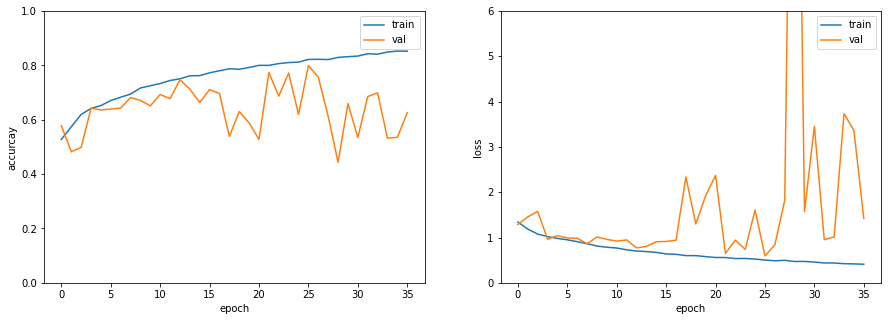

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (256,256))
  img = img/255
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = model.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 5s 83ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')

정밀도 : 0.5198
재현율 : 0.5305
f1_score : 0.5251


원본 데이터셋  | 0,3,6 2배 증강 데이터셋 ==> 0,3,6 1500장 증강

정밀도 : 0.4712 |  0.4198 ==> 0.5198

재현율 : 0.2746 |  0.3067 ==> 0.5305

f1_score : 0.3470 | 0.3545 ==> 0.5251

---

0,3,6라벨을 1500장씩 늘리고 옵티마이저를 Adam으로 바꾸고 (전에는 SGD사용) 학습률은 기본값 사용. 아직도 많이 낮긴하지만 일부 라벨 증강을 통해 큰 성능 향상을 확인할 수 있었음.  


# ResNet152 전이학습 ver1
- 0,3,6 라벨 3000장씩 증강.

In [ ]:
weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(test_labels), 
                                  y = test_labels)

weights = {i : weights[i] for i in range(7)}
weights

{0: 4.455357142857143,
 1: 2.795518207282913,
 2: 1.307994757536042,
 3: 12.96103896103896,
 4: 1.2844272844272844,
 5: 0.21279317697228145,
 6: 10.183673469387756}

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.7589
Epoch 1: val_loss improved from inf to 0.49777, saving model to /content/drive/MyDrive/skincancer_resnet152.h5
901/901 [==============================] - 151s 158ms/step - loss: 0.7139 - accuracy: 0.7589 - val_loss: 0.4978 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8444
Epoch 2: val_loss improved from 0.49777 to 0.43212, saving model to /content/drive/MyDrive/skincancer_resnet152.h5
901/901 [==============================] - 162s 180ms/step - loss: 0.4668 - accuracy: 0.8444 - val_loss: 0.4321 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8685
Epoch 3: val_loss did not improve from 0.43212
901/901 [==============================] - 156s 173ms/step - loss: 0.3887 - accuracy: 0.8685 - val_loss: 0.4823 - val_accuracy: 0.8441 - lr:

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152.h5')

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 13s 173ms/step - loss: 0.6963 - accuracy: 0.7966


[0.6963441967964172, 0.796593189239502]

In [ ]:

def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 12s 157ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6518
재현율 : 0.6566
f1_score : 0.6542
balanced_accuracy_score :  0.6566


### y_train class_weight 기준 학습


In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label


weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(y_train), 
                                  y = y_train)

weights = {i : weights[i] for i in range(7)}
# weights

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_weighted_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, class_weight=weights, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 8s 0us/step
Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.6704
Epoch 1: val_loss improved from inf to 0.80760, saving model to /content/drive/MyDrive/skincancer_weighted_resnet152.h5
901/901 [==============================] - 157s 156ms/step - loss: 1.0363 - accuracy: 0.6704 - val_loss: 0.8076 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.7783
Epoch 2: val_loss improved from 0.80760 to 0.71260, saving model to /content/drive/MyDrive/skincancer_weighted_resnet152.h5
901/901 [==============================] - 154s 171ms/step - loss: 0.6979 - accuracy: 0.7783 - val_loss: 0.7126 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.8165
Epoch 3: val_loss improved from 0.71260 to 0.61156, saving model to /content/drive/MyDrive/skincancer_

In [ ]:
ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

batch_size = 16

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_weighted_resnet152.h5')

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 22s 147ms/step - loss: 0.7391 - accuracy: 0.7796


[0.7391407489776611, 0.7795591354370117]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 11s 132ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.5678
재현율 : 0.6597
f1_score : 0.6103
balanced_accuracy_score :  0.6597


### 원본 데이터셋 y_train class_weight 학습

In [ ]:
main_path = '/content/images/'

train_paths, test_paths = [], []

for filename in train_df.image:
  train_paths.append(main_path + filename + '.jpg')

for filename in test_df.image:
  test_paths.append(main_path + filename + '.jpg')

train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

train_labels = train_df.label.values
test_labels = test_df.label.values

len(train_paths), len(train_labels), len(test_paths), len(test_labels)

(9017, 9017, 998, 998)

In [ ]:
s = np.arange(len(train_paths))
np.random.shuffle(s)

train_paths = train_paths[s]
train_labels = train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(y_train), 
                                  y = y_train)

weights = {i : weights[i] for i in range(7)}
# weights


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, class_weight=weights, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 1s 0us/step
Epoch 1/200
451/451 [==============================] - ETA: 0s - loss: 1.4541 - accuracy: 0.5314
Epoch 1: val_loss improved from inf to 1.36428, saving model to /content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5
451/451 [==============================] - 96s 194ms/step - loss: 1.4541 - accuracy: 0.5314 - val_loss: 1.3643 - val_accuracy: 0.4906 - lr: 0.0010
Epoch 2/200
451/451 [==============================] - ETA: 0s - loss: 0.9262 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.36428 to 0.90759, saving model to /content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5
451/451 [==============================] - 92s 205ms/step - loss: 0.9262 - accuracy: 0.6587 - val_loss: 0.9076 - val_accuracy: 0.6657 - lr: 0.0010
Epoch 3/200
451/451 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.6872
Epoch 3: val_loss did not improve from 0.90759
451/451 [==============================] - 71

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 18s 276ms/step - loss: 0.6791 - accuracy: 0.7655


[0.6791227459907532, 0.765531063079834]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

63/63 [==============================] - 13s 133ms/step
정밀도 : 0.5896
재현율 : 0.6266
f1_score : 0.6076
balanced_accuracy_score :  0.6266


### 원본 데이터셋 ResNet152 학습

In [ ]:
s = np.arange(len(train_paths))
np.random.shuffle(s)

train_paths = train_paths[s]
train_labels = train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

# weights = class_weight.compute_class_weight(class_weight = "balanced" , 
#                                   classes=np.unique(y_train), 
#                                   y = y_train)

# weights = {i : weights[i] for i in range(7)}
# weights


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_noaug_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

Epoch 1/200
451/451 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.7242
Epoch 1: val_loss improved from inf to 0.67031, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 86s 171ms/step - loss: 0.8066 - accuracy: 0.7242 - val_loss: 0.6703 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 2/200
451/451 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.7864
Epoch 2: val_loss improved from 0.67031 to 0.66962, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 76s 169ms/step - loss: 0.5883 - accuracy: 0.7864 - val_loss: 0.6696 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 3/200
451/451 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8085
Epoch 3: val_loss improved from 0.66962 to 0.62369, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 79s 174ms/ste

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 10s 148ms/step - loss: 0.5940 - accuracy: 0.8006


[0.5939986705780029, 0.8006011843681335]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

63/63 [==============================] - 11s 135ms/step
정밀도 : 0.6814
재현율 : 0.5556
f1_score : 0.6121
balanced_accuracy_score :  0.5556


# ResNet152 전이학습 ver2
- 5번 NV 제외한 모든 라벨 3000장씩 증강.

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152_ver2.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 9s 0us/step
Epoch 1/200
1351/1351 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.6572
Epoch 1: val_loss improved from inf to 0.70449, saving model to /content/drive/MyDrive/skincancer_resnet152_ver2.h5
1351/1351 [==============================] - 232s 160ms/step - loss: 0.9244 - accuracy: 0.6572 - val_loss: 0.7045 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 2/200
1351/1351 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7649
Epoch 2: val_loss improved from 0.70449 to 0.61390, saving model to /content/drive/MyDrive/skincancer_resnet152_ver2.h5
1351/1351 [==============================] - 222s 165ms/step - loss: 0.6357 - accuracy: 0.7649 - val_loss: 0.6139 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 3/200
1351/1351 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7997
Epoch 3: val_loss improved from 0.61390 to 0.52858, saving model to /content/drive/MyDrive/skincance

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 11s 175ms/step - loss: 0.6732 - accuracy: 0.8016


[0.6732069849967957, 0.8016031980514526]

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver2.h5')

In [ ]:

def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 13s 129ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6428
재현율 : 0.6377
f1_score : 0.6402
balanced_accuracy_score :  0.6377


# ResNet152 전이학습 ver3
- 5번 NV 제외한 모든 라벨 약 5000장까지 증강

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152_ver3.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 2s 0us/step
Epoch 1/200
1851/1851 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6851
Epoch 1: val_loss improved from inf to 0.64157, saving model to /content/drive/MyDrive/skincancer_resnet152_ver3.h5
1851/1851 [==============================] - 310s 158ms/step - loss: 0.8523 - accuracy: 0.6851 - val_loss: 0.6416 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 2/200
1851/1851 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.7914
Epoch 2: val_loss improved from 0.64157 to 0.53770, saving model to /content/drive/MyDrive/skincancer_resnet152_ver3.h5
1851/1851 [==============================] - 294s 159ms/step - loss: 0.5766 - accuracy: 0.7914 - val_loss: 0.5377 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 3/200
1851/1851 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8233
Epoch 3: val_loss improved from 0.53770 to 0.48271, saving model to /content/drive/MyDrive/skincance

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 22s 163ms/step - loss: 0.8573 - accuracy: 0.7715


[0.8572513461112976, 0.7715430855751038]

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver3.h5')

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 11s 130ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.5938
재현율 : 0.6458
f1_score : 0.6187
balanced_accuracy_score :  0.6458


# Inceptionv3 전이학습
- 0,3,6번 라벨 3000장 증강

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#######################################################################################################################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label
#######################################################################################################################################

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)
#######################################################################################################################################
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

InceptionV3 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
#######################################################################################################################################
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_Inceptionv3.h5', monitor='val_loss', verbose=1, save_best_only=True)
#######################################################################################################################################
InceptionV3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = InceptionV3.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.7100
Epoch 1: val_loss improved from inf to 0.69919, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/901 [==============================] - 98s 95ms/step - loss: 0.8583 - accuracy: 0.7100 - val_loss: 0.6992 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.7917
Epoch 2: val_loss improved from 0.69919 to 0.59689, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/901 [==============================] - 85s 94ms/step - loss: 0.6139 - accuracy: 0.7917 - val_loss: 0.5969 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8174
Epoch 3: val_loss improved from 0.59689 to 0.55104, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/9

# ResNet152 앙상블

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_weighted_resnet152.h5')
resnet152_2 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152.h5')
resnet152_3 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver2.h5')
resnet152_4 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver3.h5')

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16

pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

models = [resnet152, resnet152_2, resnet152_3, resnet152_4]
y_pred = [model.predict(pred_test_dataset) for model in models]
pred_sum = np.sum(y_pred, axis=0)
label_pred = np.argmax(pred_sum, axis=1)

63/63 [==============================] - 11s 127ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6237
재현율 : 0.6552
f1_score : 0.6390
balanced_accuracy_score :  0.6552


In [ ]:
cm = confusion_matrix(test_labels, label_pred)
cm

array([[ 17,   5,   5,   0,   5,   0,   0],
       [  6,  31,   6,   2,   0,   6,   0],
       [  6,   2,  64,   3,  17,  17,   0],
       [  0,   0,   0,   9,   1,   1,   0],
       [  2,   2,  20,   0,  45,  39,   3],
       [  1,   6,  10,   2,  31, 618,   2],
       [  0,   0,   0,   1,   1,   2,  10]])

In [ ]:
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [ ]:
report_df = pd.DataFrame(classification_report(test_labels, label_pred, target_names=class_names, output_dict=True)).T
report_df

,precision,recall,f1-score,support
AKIEC,0.531250,0.531250,0.531250,32.000000
BCC,0.673913,0.607843,0.639175,51.000000
BKL,0.609524,0.587156,0.598131,109.000000
DF,0.529412,0.818182,0.642857,11.000000
MEL,0.450000,0.405405,0.426540,111.000000
NV,0.904832,0.922388,0.913525,670.000000
VASC,0.666667,0.714286,0.689655,14.000000
accuracy,0.795591,0.795591,0.795591,0.795591
macro avg,0.623657,0.655216,0.634448,998.000000
weighted avg,0.790733,0.795591,0.792514,998.000000


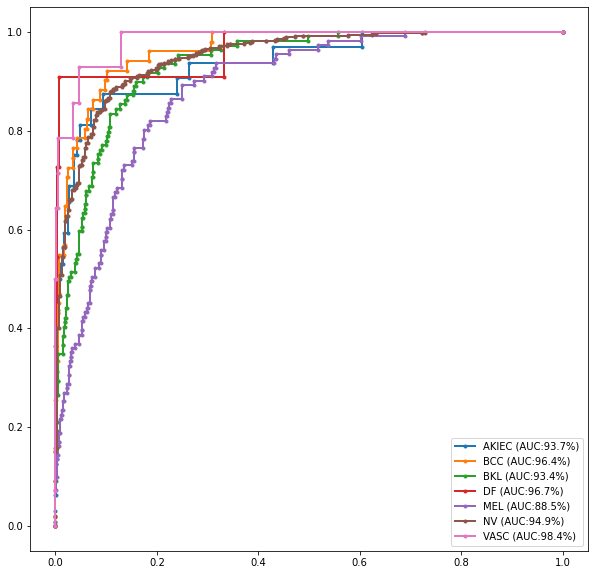

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_test_ohe = ohe.fit_transform(test_labels.reshape(-1,1))
prediction = pred_sum

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
for i, c_all in enumerate(class_names):
    tpr, fpr, thresh = roc_curve(y_true=y_test_ohe[:, i], y_score=prediction[:, i])
    auc_roc = roc_auc_score(y_true=y_test_ohe[:, i], y_score=prediction[:, i]) # 각 라벨에 대한 auc값을 구함.
    ax1.plot(tpr, fpr, '.-', label='{} (AUC:{:2.1%})'.format(c_all, auc_roc), lw=2)
ax1.legend()